# Determining Causal Graph from Binary Structure Tests

In [30]:
import sys
sys.path.insert(0, '../..')

In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange as tnrange
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

from cs330.data_generators.multivariate_categorical import MultiCategorical
from cs330.data_generators.causal_graph import CausalGraph
from cs330.models.augmented_binary_models import *
from cs330.models.augmented_binary_model_trainer import *

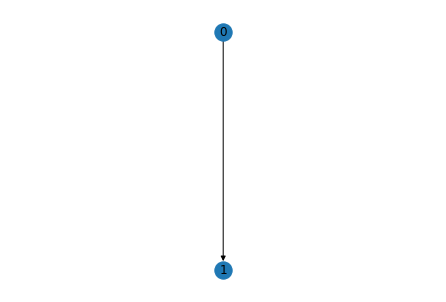

In [38]:
# Set up graph

'''
N = 10
M = 3

data_gen = MultiCategorical(N, M)
data_gen.graph.B = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [1, 0, 0]
])
'''

N = 10
M = 2
data_gen = MultiCategorical(N, M)
data_gen.graph.B = np.array([
    [0, 0],
    [1, 0]
])

# Visualize
data_gen.graph.visualize()

In [39]:
# Choose model type to test pairwise binary connections

BINARY_MODEL_TYPE = CauseOnlyBinaryStructureModel

In [40]:
# Binary Test Training Constants
INNER_LR = 1e-1
OUTER_LR = 1e-2
TRANSFER_EPISODE_COUNT = 500
TRANSFER_EPISODE_GRADIENT_STEPS = 30
TRANSFER_EPISODE_BATCH_SIZE = 250
PRETRAIN_EPISODE_BATCH_SIZE = 500

In [41]:
# Iterate through all node pairs and save resulting predicted structures
node_pairs = []
for A in range(M - 1):
    for B in range(A + 1, M):
        node_pairs.append((A, B))

structure_predictions = {}
for i in tnrange(len(node_pairs)):
    A, B = node_pairs[i]

    model = BINARY_MODEL_TYPE(N, M, A, B)
    model_handler = AugmentedBinaryModelTrainer(
        data_gen, model,
        inner_lr = INNER_LR,
        outer_lr = OUTER_LR,
        transfer_episode_count = TRANSFER_EPISODE_COUNT,
        transfer_episode_gradient_steps = TRANSFER_EPISODE_GRADIENT_STEPS,
        transfer_episode_batch_size = TRANSFER_EPISODE_BATCH_SIZE,
        pretrain_episode_batch_size = PRETRAIN_EPISODE_BATCH_SIZE
    )

    # Meta-learn structure
    model_handler.train_structure()

    # Save resulting structure prediction
    structure_predictions[(A, B)] = {
        hypothesis: prob for hypothesis, prob in zip(model.hypotheses(), model.structure_likelihoods().tolist())
    }

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

../../cs330/models/augmented_binary_models.py:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_hypothesis_online_logL = log_softmax_weights + hypothesis_online_log_likelihoods


In [42]:
structure_predictions

{(0, 1): {<Hypothesis.FORWARD_CAUSE: 1>: 0.7863295674324036,
  <Hypothesis.BACKWARD_CAUSE: 2>: 0.21367044746875763}}

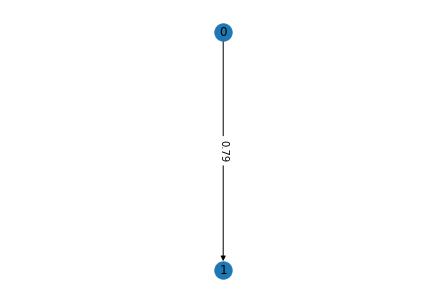

In [43]:
# Visualize graph resulting from these predictions
predicted_graph = nx.DiGraph()
for (A, B), binary_structure in structure_predictions.items():
    max_structure_prob = max(*binary_structure.values())
    if binary_structure[Hypothesis.FORWARD_CAUSE] == max_structure_prob:
        predicted_graph.add_edge(A, B, weight = round(binary_structure[Hypothesis.FORWARD_CAUSE], 2))
    elif binary_structure[Hypothesis.BACKWARD_CAUSE] == max_structure_prob:
        predicted_graph.add_edge(B, A, weight = round(binary_structure[Hypothesis.BACKWARD_CAUSE], 2))

pos = graphviz_layout(predicted_graph, prog='dot')
edge_labels = nx.get_edge_attributes(predicted_graph, 'weight')
nx.draw(predicted_graph, with_labels = True, pos = pos)
nx.draw_networkx_edge_labels(predicted_graph, pos, edge_labels = edge_labels)
plt.show()